In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

__Імопрт данних__

In [2]:
df = sm.datasets.sunspots.load_pandas().data
df

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
...,...,...
304,2004.0,40.4
305,2005.0,29.8
306,2006.0,15.2
307,2007.0,7.5


_Змінюю назви колонок, та виставляю колонку роки як індекс_

In [3]:
df.columns = ['year', 'sunactivity']
df.columns

Index(['year', 'sunactivity'], dtype='object')

In [4]:
df ['year']=pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace= True)
df

,sunactivity
year,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
2004-01-01,40.4
2005-01-01,29.8
2006-01-01,15.2


In [5]:
df.columns

Index(['sunactivity'], dtype='object')

___Будуємо графік сонячної активності___

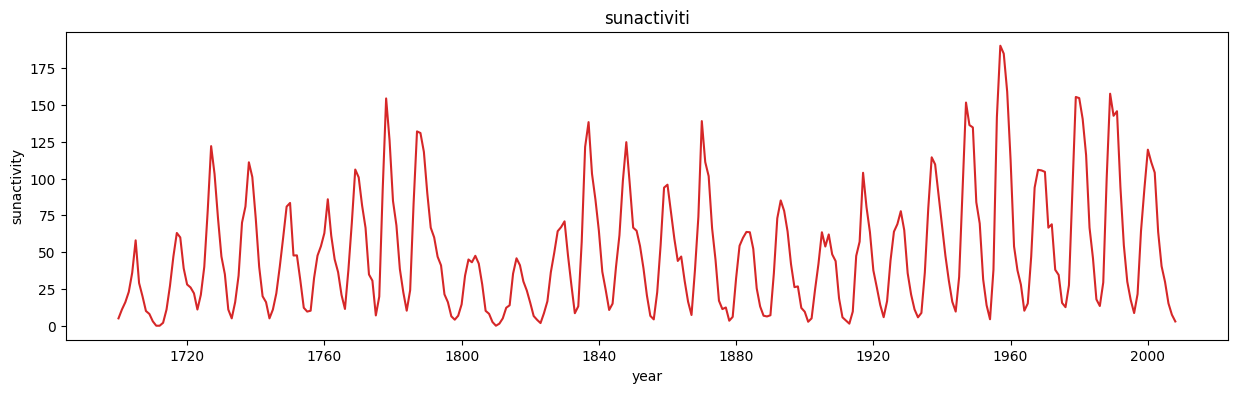

In [6]:
plt.figure(figsize=(15,4), dpi=100)
plt.plot(df, color='tab:red')
plt.gca().set(title='sunactiviti', xlabel='year', ylabel='sunactivity')
plt.show()

Як видно з графіку є сезонність, явних екзогенних викидів  немає.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

Text(0.5, 0.98, 'Адитивная модель')

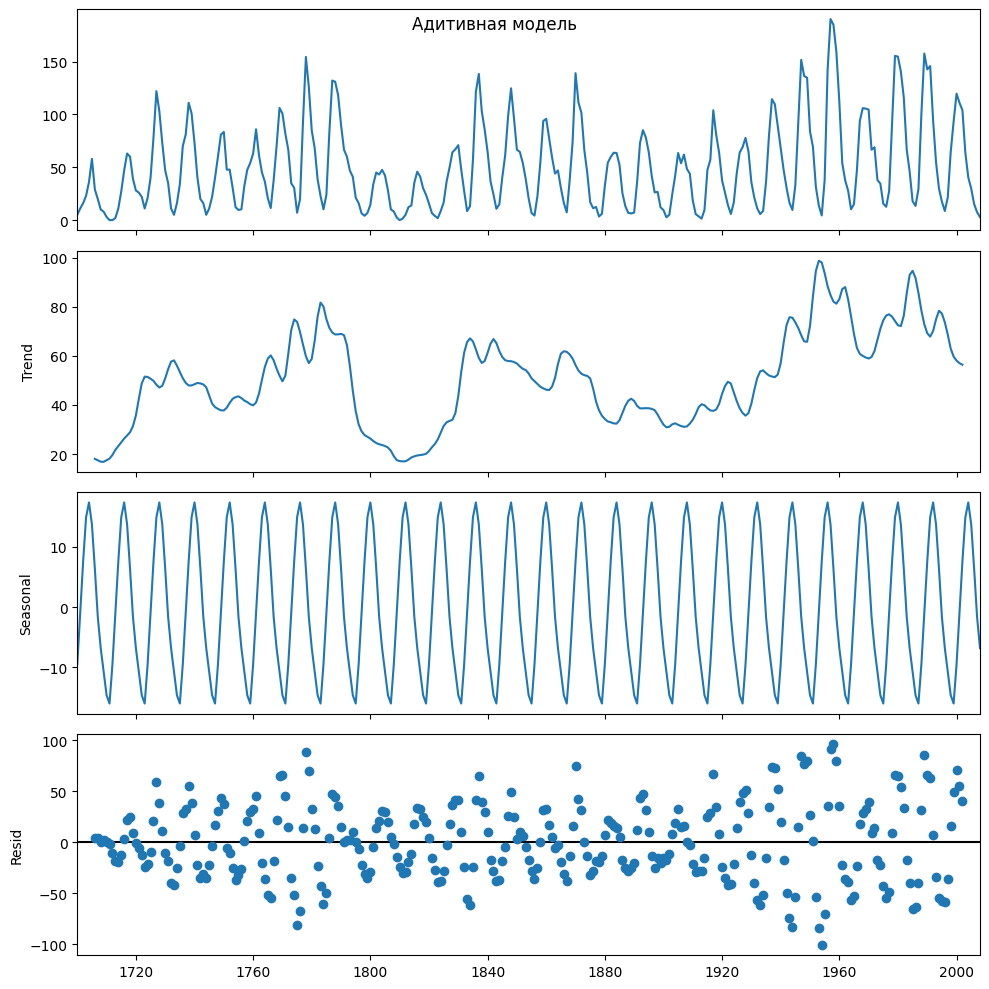

In [8]:
# Адитивна декомпозиція
result_A = seasonal_decompose(df, model='additive',period=12)

# Побудова графіка
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Адитивная модель')

За допомогої адативної декомпозиція бачимо що є явна сезонність

__Визначаємо вхідні параметри для моделі ARIMA__

In [9]:
# Визначення p, d і q у діапазоні 0-3
p = d = q = range(0, 4)
# Генеруємо різні комбінації p, q и q
pdq = list(itertools.product(p, d, q))
len(pdq)

64

In [10]:
warnings.filterwarnings("ignore") # Вимикаємо попередження
min_aic = float('inf')
parametr_pdq = None
for param in pdq:
    try:
        mod = sm.tsa.ARIMA(df,order=param)
        results = mod.fit()
        aic = results.aic
        if aic < min_aic:
            min_aic = aic
            parametr_pdq = param

    except:
        continue
print(f'ARIMA{parametr_pdq} - AIC:{min_aic}')

ARIMA(2, 1, 3) - AIC:2572.9543327958895


Найкращі параметри pdq є (2, 1, 3) та передаємо їх на модель та навчаємо .

In [11]:
mod = sm.tsa.ARIMA(df,order=parametr_pdq)
results = mod.fit()

In [12]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            sunactivity   No. Observations:                  309
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1280.477
Date:                Sun, 03 Sep 2023   AIC                           2572.954
Time:                        12:31:26   BIC                           2595.335
Sample:                    01-01-1700   HQIC                          2581.903
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6145      0.026     62.096      0.000       1.564       1.665
ar.L2         -0.9354      0.022    -41.820      0.000      -0.979      -0.892
ma.L1         -1.4392      0.059    -24.590      0.0

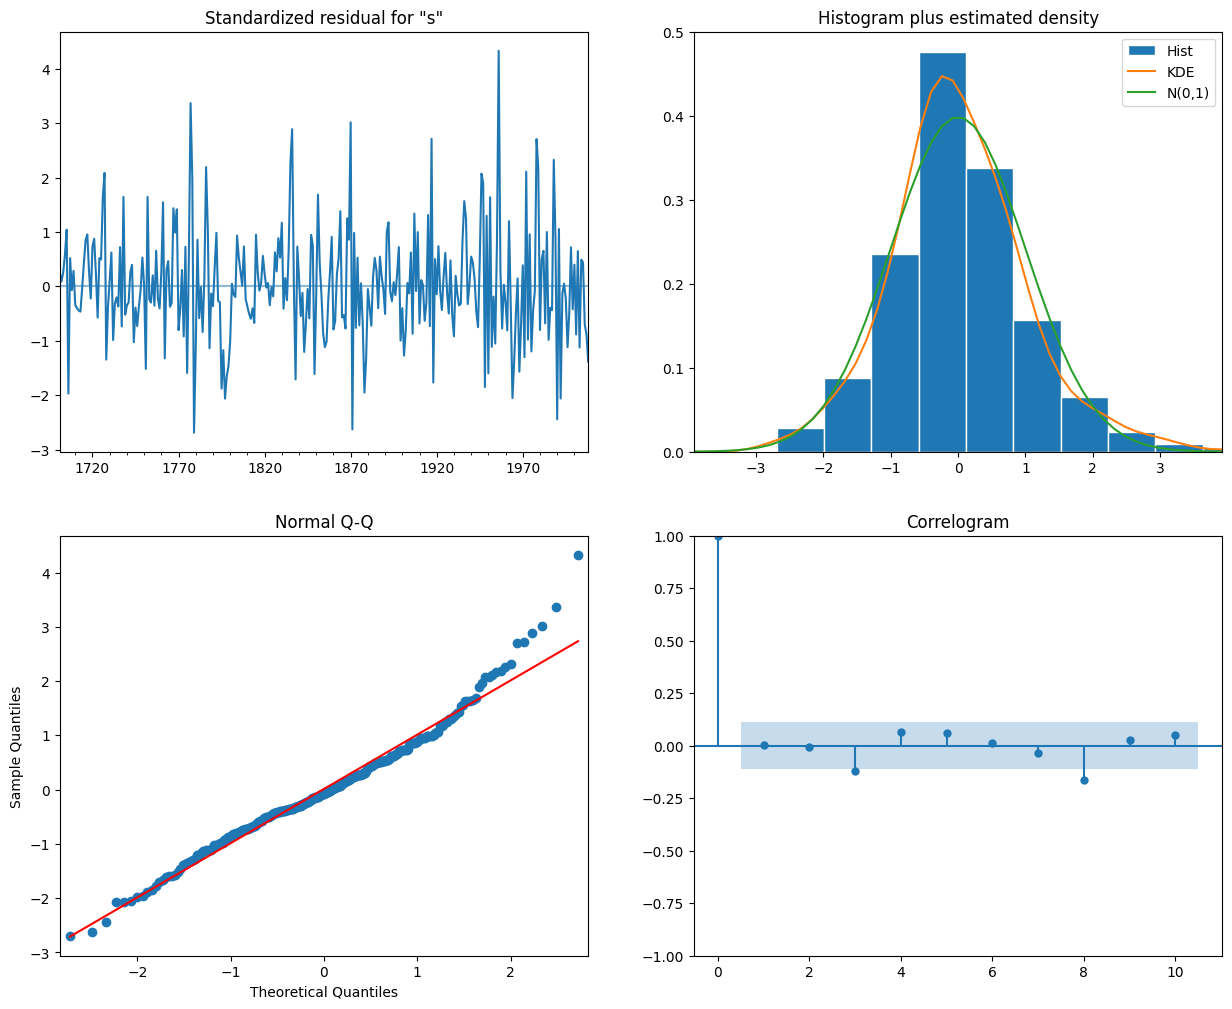

In [13]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Статична предикція

In [14]:
pred = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
pred_ci = pred.conf_int()



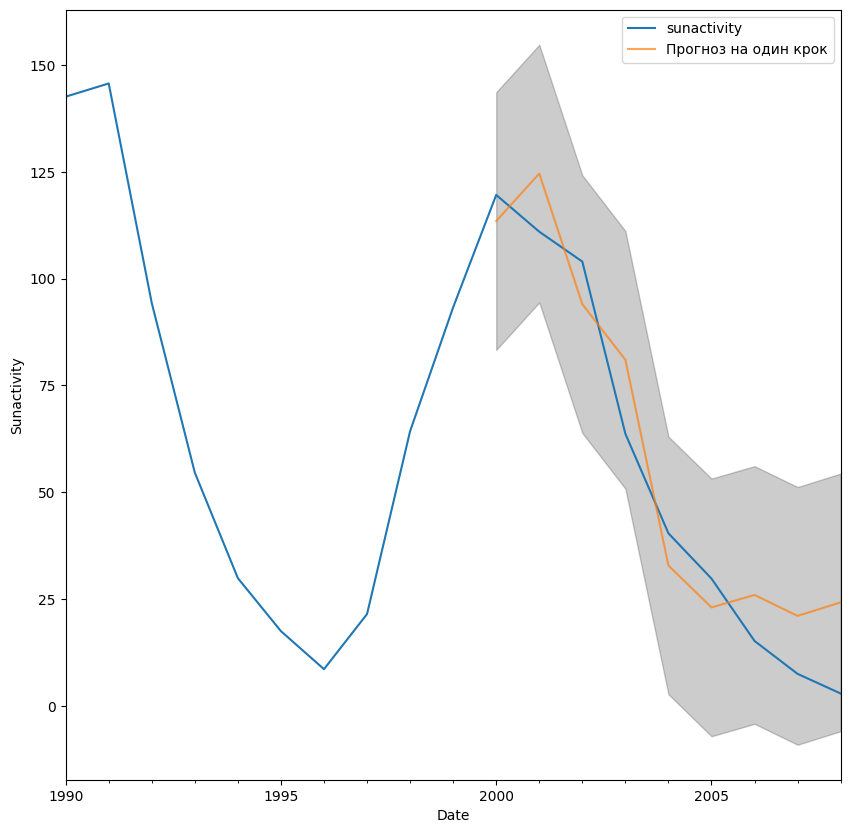

In [15]:
ax = df['1990':].plot(label='Відомі')
pred.predicted_mean.plot(ax=ax, label='Прогноз на один крок', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sunactivity')
plt.legend()
plt.show()

 Обчислюємо середню квадртичну похибку

In [16]:
y_forecasted = pred.predicted_mean
y_truth = df['2000-01-01':]['sunactivity'] 
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Середня квадратна похибка прогнозів = {}'.format(round(mse, 2)))

Середня квадратна похибка прогнозів = 164.3


Динамічна пердикція

In [17]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

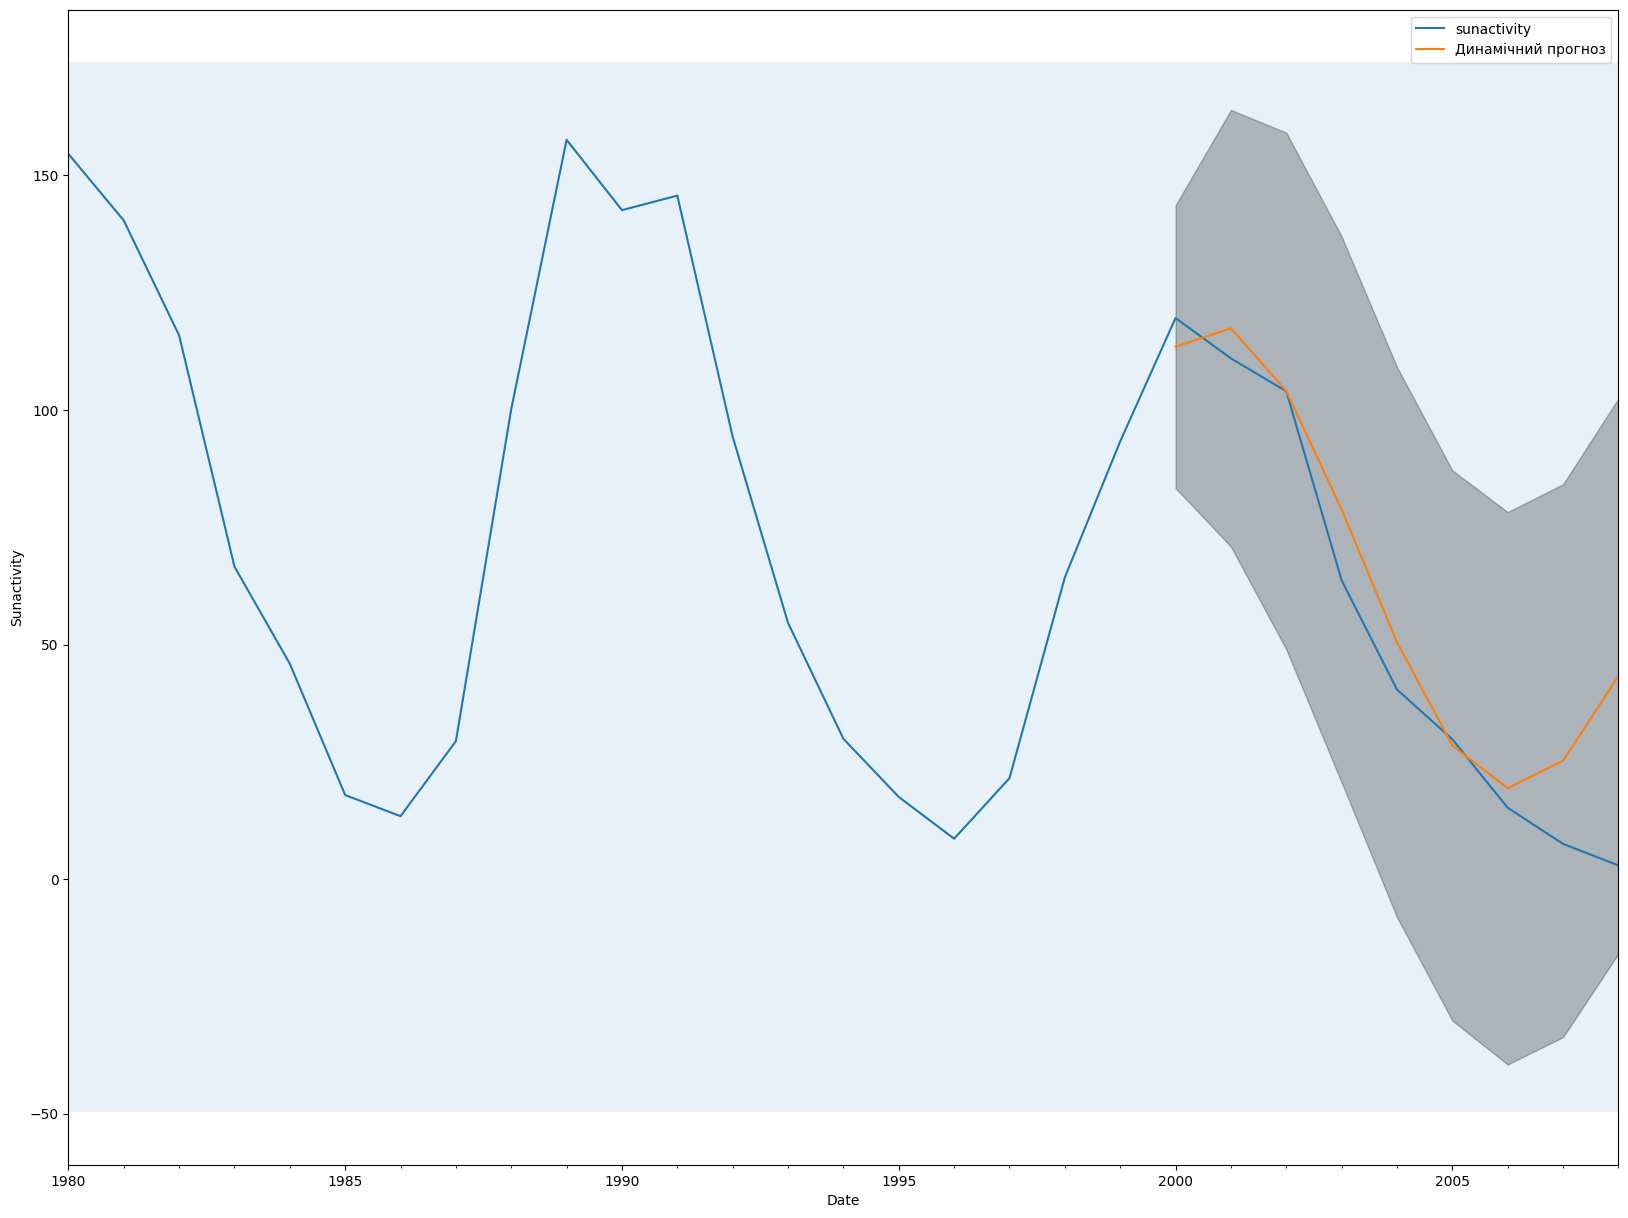

In [18]:
ax = df['1980':].plot(label='Відомі', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Динамічний прогноз', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
pred_dynamic_ci.iloc[:, 0],
pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1980-01-01'), df.index[-1],
alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Sunactivity')
plt.legend()
plt.show()

___Отримуємо прогноз до  2030 року___

In [19]:

pred_uc = results.get_forecast(steps=22)
pred_ci = pred_uc.conf_int()

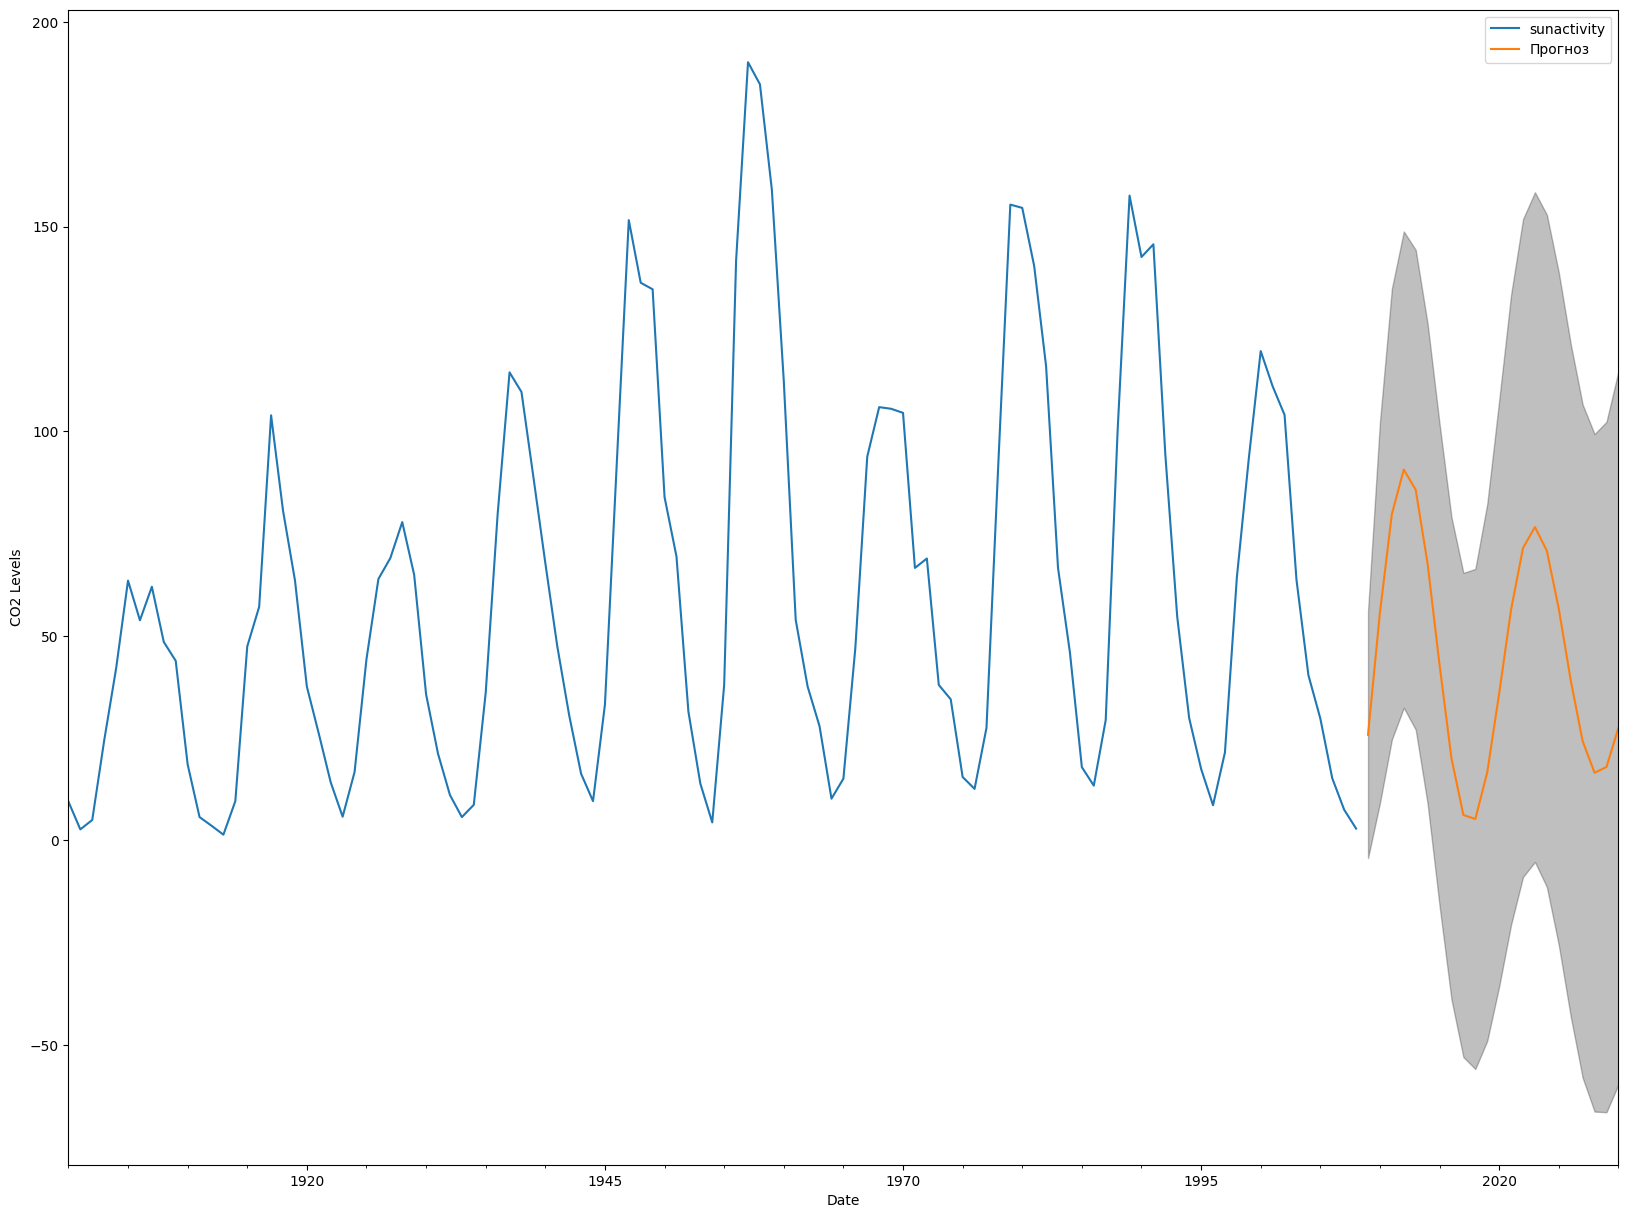

In [20]:
ax = df['1900':].plot(label='Відомі', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()